In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
omp = 1
mpi = 4

# Analysis of the electron-phonon coupling 

We analyze the effects of the electron-phonon coupling in the electronic and optical properties
of bulk Si.

This analysis is base on the web page : https://www.yambo-code.eu/wiki/index.php/Electron_Phonon_Coupling




In [4]:
run_dir = 'Electron_phonon_Si'

Due to the way in which the ph.x is implemented it is more convenient to run each step of the calculations
in a specific folder. So the prefix of all the computations is the same but they are exectuded in differen paths. 

## SCF and NSCF calculations

In [5]:
rr = C.RunRules(mpi=mpi,omp_num_threads=omp)
code = C.QeCalculator(rr)
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler direct


{'scheduler': 'direct',
 'mpi': 4,
 'omp_num_threads': 1,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True}

First we perform a scf calculation on a 8x8x8 k grid to ensure that the electronic density of the GS is converged.

The convergence threshold is set to 1e-12, this value and k grid are loosend w.r.t. the paramteres used in the original
tutorial to redcue computational time.

Note that, following the Yambo tutorial, the geometry of the lattice is set using ibrav=0 with the explicit values of the cell
parameters. This is done to avoid possible incompatibility between the PW and Yambo conventions for the FCC lattice.

In [8]:
prefix = 'si'
name = 'si.scf'
inp= I.PwInput(file='IO_files/Input_for_electron_phonon_Si_tutorial/si.scf.in')
inp.set_prefix(prefix)
inp.set_pseudo_dir('pseudos',abs_path=True)
#print(inp.convert_string())

In [7]:
scf_run_dir = os.path.join(run_dir,'scf')
results = code.run(input=inp,run_dir=scf_run_dir,name=name)
results

create the run_dir folder : 'Electron_phonon_Si/scf'
run command: mpirun -np 4 pw.x -inp si.scf.in > si.scf.log
computation si.scf is running...
computation si.scf ended


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


'/home/marco/Applications/MPPI/sphinx_source/tutorials/Electron_phonon_Si/scf/si.save/data-file-schema.xml'

Then we perform a nscf calculation on a smaller 4x4x4 grid with 12 bands.

In [10]:
inp.set_nscf(12,force_symmorphic=True,conv_thr=1e-12)
inp.set_kpoints(points=[4,4,4])
#print(inp.convert_string())

In [11]:
nscf_run_dir = os.path.join(run_dir,'nscf')
results = code.run(input=inp,run_dir=nscf_run_dir,name=prefix,source_dir=os.path.join(scf_run_dir,prefix+'.save'))
results

create the run_dir folder : 'Electron_phonon_Si/nscf'
copy source_dir Electron_phonon_Si/scf/si.save in the /home/marco/Applications/MPPI/sphinx_source/tutorials/Electron_phonon_Si/nscf/si.save
run command: mpirun -np 4 pw.x -inp si.in > si.log
computation si is running...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


computation si ended


'/home/marco/Applications/MPPI/sphinx_source/tutorials/Electron_phonon_Si/nscf/si.save/data-file-schema.xml'

In [12]:
data = P.PwParser(results)

Parse file : /home/marco/Applications/MPPI/sphinx_source/tutorials/Electron_phonon_Si/nscf/si.save/data-file-schema.xml


In [13]:
kpoints=-data.kpoints
#kpoints[4] = np.array([-0.375000000,-0.125000000,0.125000000])
kpoints

array([[-0.   , -0.   , -0.   ],
       [-0.125, -0.125,  0.125],
       [ 0.25 ,  0.25 , -0.25 ],
       [-0.25 , -0.   , -0.   ],
       [ 0.125,  0.375, -0.375],
       [-0.   ,  0.25 , -0.25 ],
       [ 0.5  , -0.   , -0.   ],
       [ 0.5  , -0.25 , -0.   ]])

## Phonon calculations

With this calculation we can compute the dynamical matrix elements and the dvscf files, these quantities are the 
analougous of the GS density for the phonon calculations

In [139]:
rr = C.RunRules(mpi=mpi,omp_num_threads=omp)
code_ph = C.QeCalculator(rr,executable='ph.x')
#code_ph.global_options()

Initialize a QuantumESPRESSO calculator with scheduler direct


In [16]:
prefix = 'si'
name = 'si.phonon'
inp = I.PhInput()
inp.set_prefix(prefix)
inp['inputph']['fildvscf'] = "'si-dvscf'"
inp['inputph']['fildyn'] = "'si.dyn'"
inp['inputph']['electron_phonon'] = "'dvscf'"
inp['inputph']['epsil'] = '.true.'
inp.set_kpoints(Tools.build_pw_klist(kpoints))
#print(inp.convert_string())

In [17]:
ph_run_dir = os.path.join(run_dir,'phonon')
results = code_ph.run(input=inp,run_dir=ph_run_dir,name=name,source_dir=os.path.join(scf_run_dir,prefix+'.save'))

create the run_dir folder : 'Electron_phonon_Si/phonon'
copy source_dir Electron_phonon_Si/scf/si.save in the /home/marco/Applications/MPPI/sphinx_source/tutorials/Electron_phonon_Si/phonon/si.save
run command: mpirun -np 4 ph.x -inp si.phonon.in > si.phonon.log
computation si.phonon is running...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


computation si.phonon ended


Once that the si.dyn* files and the dvscf files in the _ph0_ have been computed we can calculate the electron-phonon matrix elements. 

We copy these files in the run_dir of the dvscf computation for the evaluation of the electron-phonon matrix elements.

In [18]:
dvscf_run_dir = os.path.join(run_dir,'dvscf')
if not os.path.isdir(dvscf_run_dir) : os.mkdir(dvscf_run_dir)
os.system('cp -r Electron_phonon_Si/phonon/_ph0/ Electron_phonon_Si/phonon/si.dyn* Electron_phonon_Si/dvscf')
os.system('cp -r Electron_phonon_Si/nscf/si.save/ Electron_phonon_Si/dvscf/')

0

In this case we use the nscf computations as starting point for the electronic quantities. Note that the calculator 
uses the option clean_restart=False. otherwise the dyn and ph0 files are erased.

In [20]:
prefix = 'si'
name = 'si.dvscf'
inp = I.PhInput()
inp.set_prefix(prefix)
inp['inputph']['fildvscf'] = "'si-dvscf'"
inp['inputph']['fildyn'] = "'si.dyn'"
inp['inputph']['electron_phonon'] = "'yambo'"
inp['inputph']['trans'] = '.false.'
inp.set_kpoints(Tools.build_pw_klist(kpoints))
#print(inp.convert_string())

In [21]:
results = code_ph.run(input=inp,run_dir=dvscf_run_dir,name=name,clean_restart=False)

run performed starting from existing results
run command: mpirun -np 4 ph.x -inp si.dvscf.in > si.dvscf.log
computation si.dvscf is running...


Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


computation si.dvscf ended


## Import in yambo

We use ypp_ph to generate the electron-phonon database that can be used by yambo.

This procedure convert the file written in the dvscf/elph_dir

In [22]:
source_dir = 'Electron_phonon_Si/dvscf/si.save'
run_dir = 'Electron_phonon_Si/yambo'
Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

Executing command: cd Electron_phonon_Si/dvscf/si.save; p2y
Create folder path Electron_phonon_Si/yambo
Create a symlink of Electron_phonon_Si/dvscf/si.save/SAVE in Electron_phonon_Si/yambo
Build the r_setup in the run_dir path Electron_phonon_Si/yambo


In [23]:
inp = I.YamboInput(args='ypp_ph -g g',folder=run_dir)
inp.set_scalar_variables(DBsPATH='../dvscf/elph_dir/')
inp

{'args': 'ypp_ph -g g',
 'folder': 'Electron_phonon_Si/yambo',
 'filename': 'yambo.in',
 'arguments': ['gkkp'],
 'variables': {'PHfreqF': 'none',
  'PHmodeF': 'none',
  'DBsPATH': '../dvscf/elph_dir/'}}

In [24]:
rr = C.RunRules(mpi=mpi,omp_num_threads=omp)
code = C.YamboCalculator(rr,executable='ypp_ph')
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [25]:
name= 'elph_import'
code.run(input=inp,name=name,run_dir=run_dir)

run command: mpirun -np 4 ypp_ph -F elph_import.in -J elph_import -C elph_import
computation elph_import is running...
computation elph_import ended

        There are no o-* files.
        Maybe you have performed a computation that does not create any output file or wait_end_run
        and/or the dry_run option are active.
        Otherwise a possible error has occured during the computation
        


{'output': {},
 'report': 'Electron_phonon_Si/yambo/elph_import/r-elph_import_gkkp_gkkp_db',
 'dft': 'Electron_phonon_Si/yambo/SAVE/ns.db1',
 'elph_gkkp': 'Electron_phonon_Si/yambo/elph_import/ndb.elph_gkkp'}

## Quasi-particle band structure

In [41]:
rr = C.RunRules(mpi=mpi,omp_num_threads=omp)
code = C.YamboCalculator(rr,executable='yambo_ph')
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [42]:
source_dir = 'Electron_phonon_Si/dvscf/si.save'
run_dir = 'Electron_phonon_Si/yambo'
Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

SAVE folder Electron_phonon_Si/dvscf/si.save/SAVE already present. No operations performed.
SAVE folder already present in Electron_phonon_Si/yambo. No operations performed.


We include the path of the folder with e-p matrix elements using the -J option. Alternatively we could copy the
e-p database in the SAVE folder

In [126]:
inp = I.YamboInput(args='yambo_ph -g n -p fan -c ep -V gen -J elph_import',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units='eV',GDamping=0.01)
inp.set_kRange(1,1)
inp

{'args': 'yambo_ph -g n -p fan -c ep -V gen -J elph_import',
 'folder': 'Electron_phonon_Si/yambo',
 'filename': 'yambo.in',
 'arguments': ['gw0', 'el_ph_corr', 'ExtendOut'],
 'variables': {'Nelectro': [8.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'MEM_tresh': [51200.0, 'Kb'],
  'SE_Threads': [0.0, ''],
  'GDamping': [0.01, 'eV'],
  'RandQpts': [0.0, ''],
  'DysSolver': 'n',
  'GphBRnge': [[1, 12], ''],
  'ElPhModes': [[1, 6], ''],
  'QPkrange': [[1, 1, 1, 12], '']}}

In [138]:
Temp = [0,50,100,150,200,250,300]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for T in Temp:
    inp.set_array_variables(units='K',BoseTemp=T)
    idd = 'elph_T%s'%T
    study.append_run(id=idd,input=inp,runner=code,jobname =[idd,'elph_import'])

Initialize a Dataset with 2 parallel tasks


In [134]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'Electron_phonon_Si/yambo',
 'num_tasks': 2,
 'verbose': True,
 'skip': False,
 'input': {'args': 'yambo_ph -g n -p fan -c ep -V gen -J elph_import',
  'folder': 'Electron_phonon_Si/yambo',
  'filename': 'yambo.in',
  'arguments': ['gw0', 'el_ph_corr', 'ExtendOut'],
  'variables': {'Nelectro': [8.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [0, 'K'],
   'OccTresh': [1e-05, ''],
   'MEM_tresh': [51200.0, 'Kb'],
   'SE_Threads': [0.0, ''],
   'GDamping': [0.01, 'eV'],
   'RandQpts': [0.0, ''],
   'DysSolver': 'n',
   'GphBRnge': [[1, 12], ''],
   'ElPhModes': [[1, 6], ''],
   'QPkrange': [[1, 1, 1, 12], '']}},
 'jobname': ['elph_T0', 'elph_import'],
 'name': 'elph_T0'}

In [135]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6]] 

Run the task [0, 1] 
delete folder:delete folder:  Electron_phonon_Si/yambo/elph_T50Electron_phonon_Si/yambo/elph_T0

run command: mpirun -np 4 yambo_ph -F elph_T0.in -J "elph_T0,elph_import" -C elph_T0run command: mpirun -np 4 yambo_ph -F elph_T50.in -J "elph_T50,elph_import" -C elph_T50

computation elph_T0 is running...computation elph_T50 is running...

computation elph_T0 endedcomputation elph_T50 ended

Task [0, 1] ended 
 
Run the task [2, 3] 
delete folder:delete folder:  Electron_phonon_Si/yambo/elph_T100
Electron_phonon_Si/yambo/elph_T150
run command: mpirun -np 4 yambo_ph -F elph_T100.in -J "elph_T100,elph_import" -C elph_T100
run command: mpirun -np 4 yambo_ph -F elph_T150.in -J "elph_T150,elph_import" -C elph_T150
computation elph_T100 is running...
computation elph_T150 is running...
computation elph_T100 ended
computation elph_T150 ended
Task [2, 3] ended 
 
Run the task

In [136]:
gap_G = [results[ind].data.get_gap(k_full=1,band_full=4,verbose=False) for ind in range(len(Temp))]
gap_G

[2.481261, 2.484257, 2.48887, 2.4916579999999997, 2.490541, 2.485434, 2.477773]

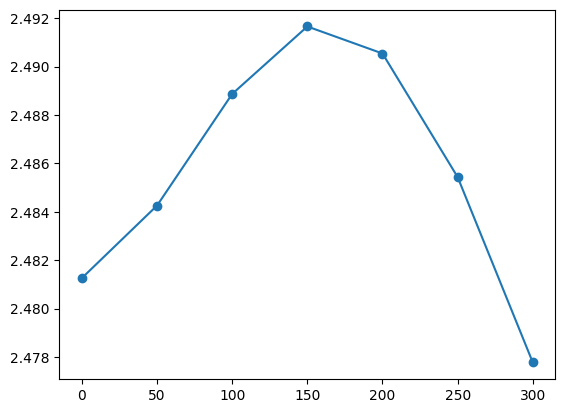

In [137]:
plt.plot(Temp,gap_G)
plt.scatter(Temp,gap_G)

The behavior is unxpected.....